This notebook demonstrates performance of VAR model. Model's parameters can be changed in the corresponding sections here. Prediction performance only.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [3]:
from statsmodels.tsa.api import VAR

In [4]:
# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.weather as weather_data

## Data preprocessing

In [5]:
# names of observed signals
sig_names = ['Average Temperature', 'Precipitation', 'Average Pressure']
# measure units
sig_units = ['$^\circ C$', 'Mm', 'HPa']

num_signals = 3

In [6]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = weather_data.GetBerlinData(
    test_ratio=0.2
)

In [7]:
print(f'Train length = {train_data.shape[0]}')
print(f'Test length = {test_data.shape[0]}')

Train length = 2921
Test length = 731


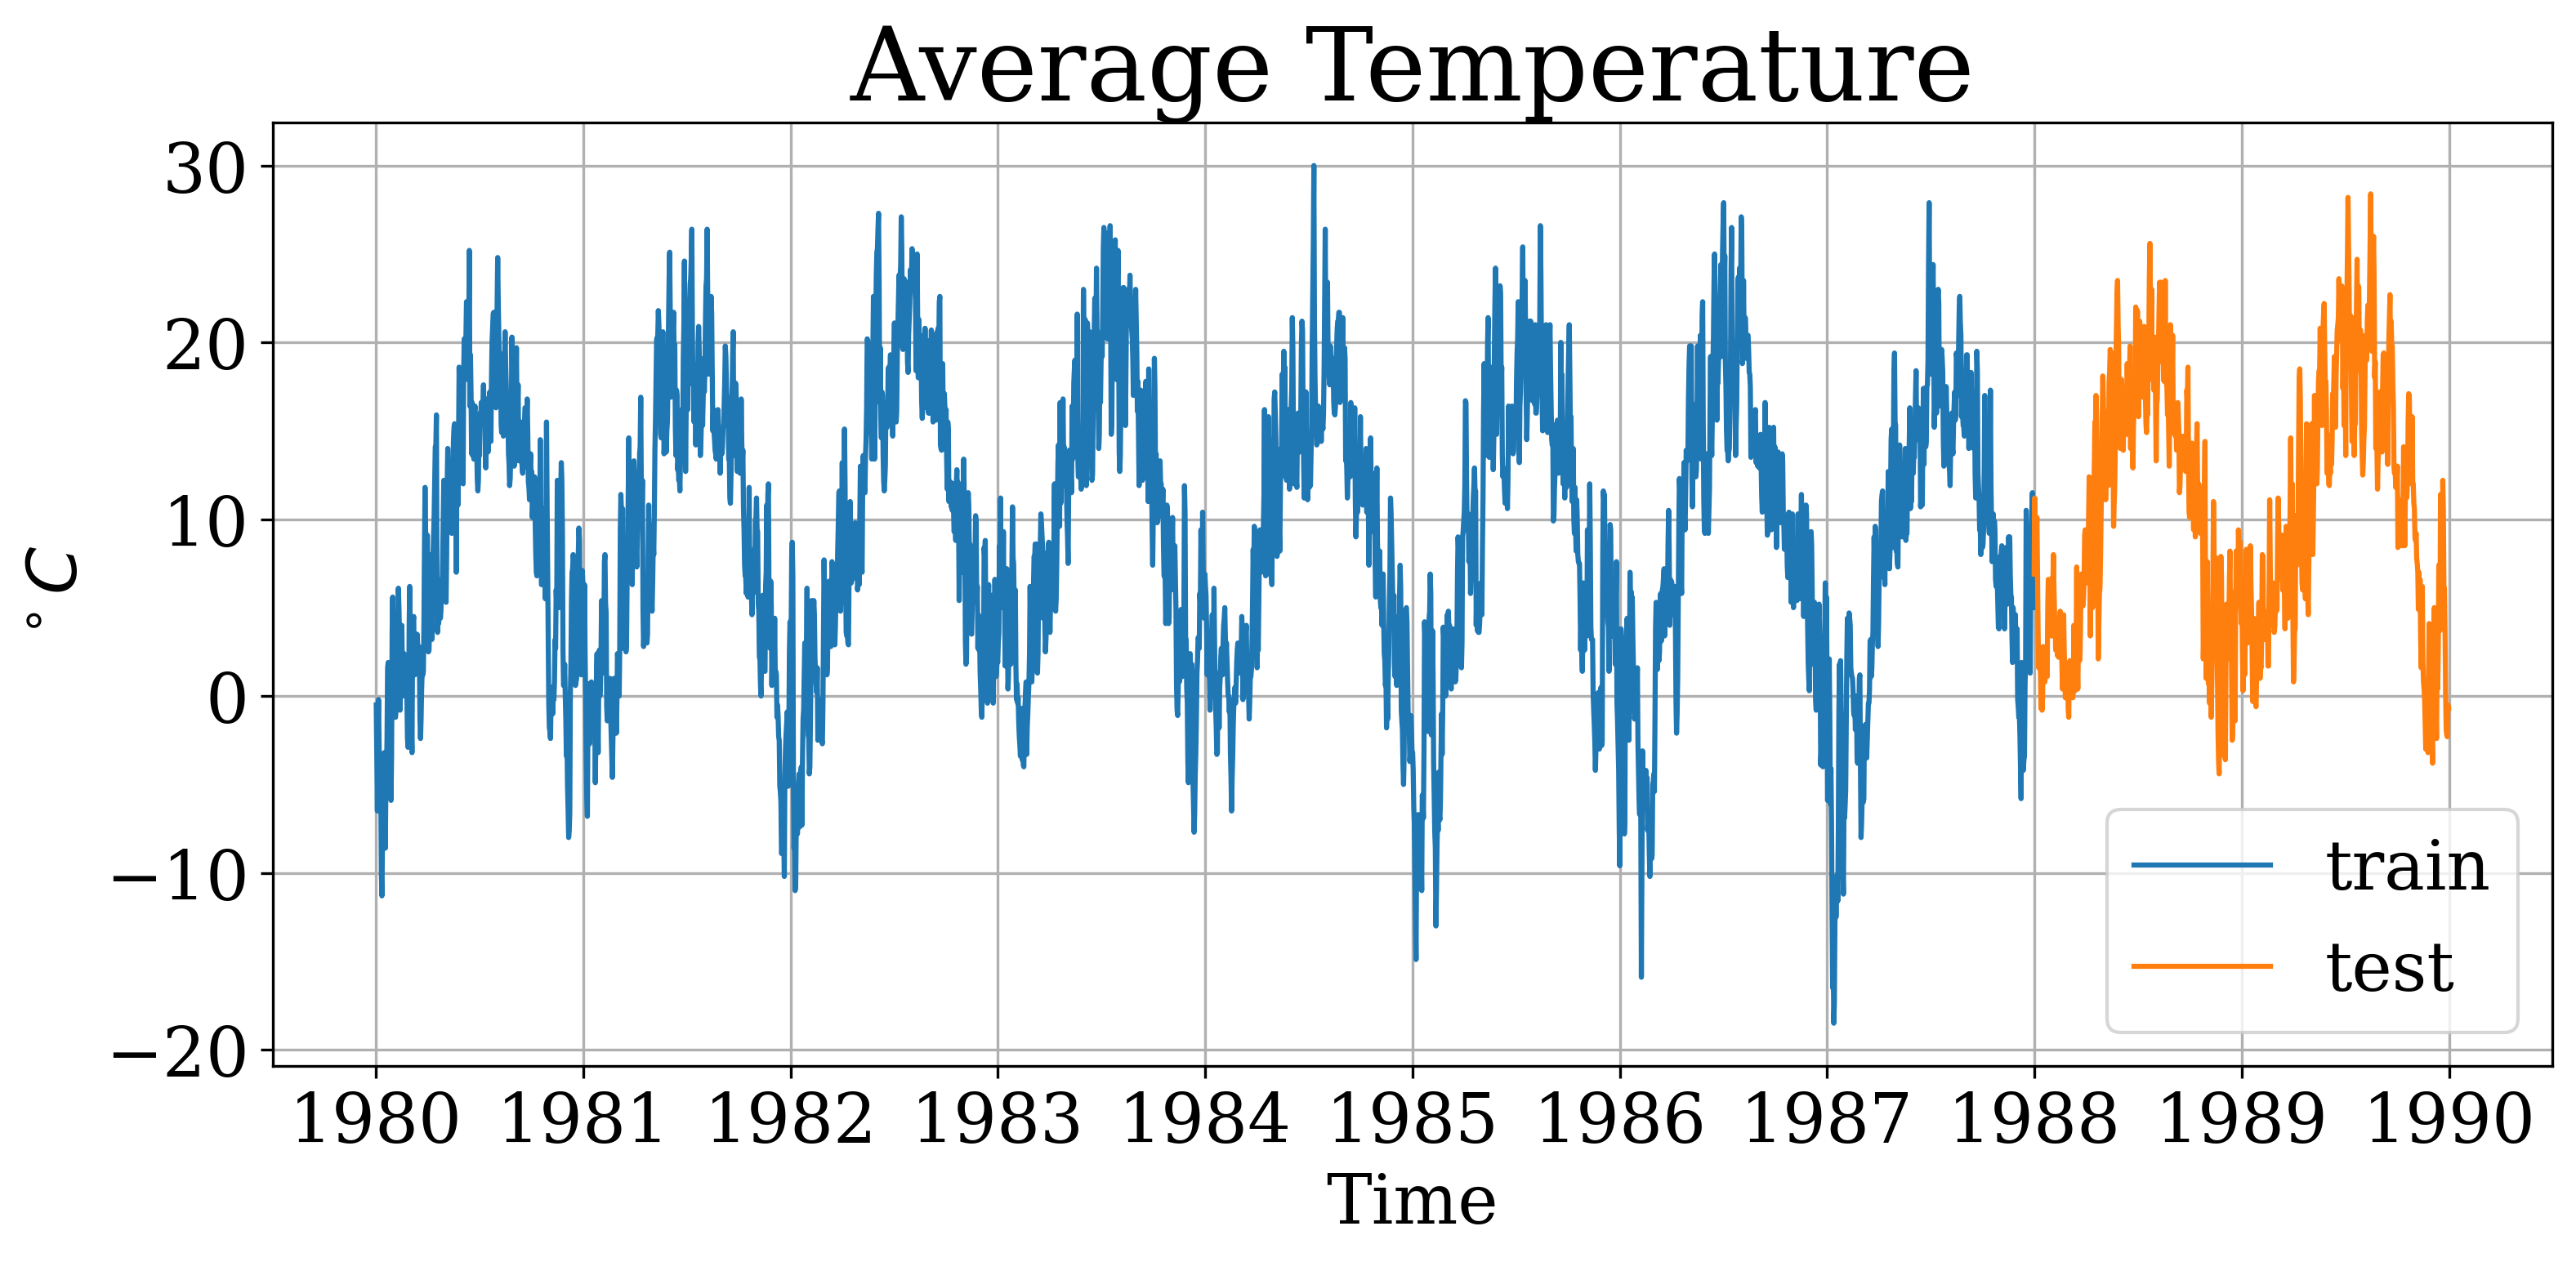

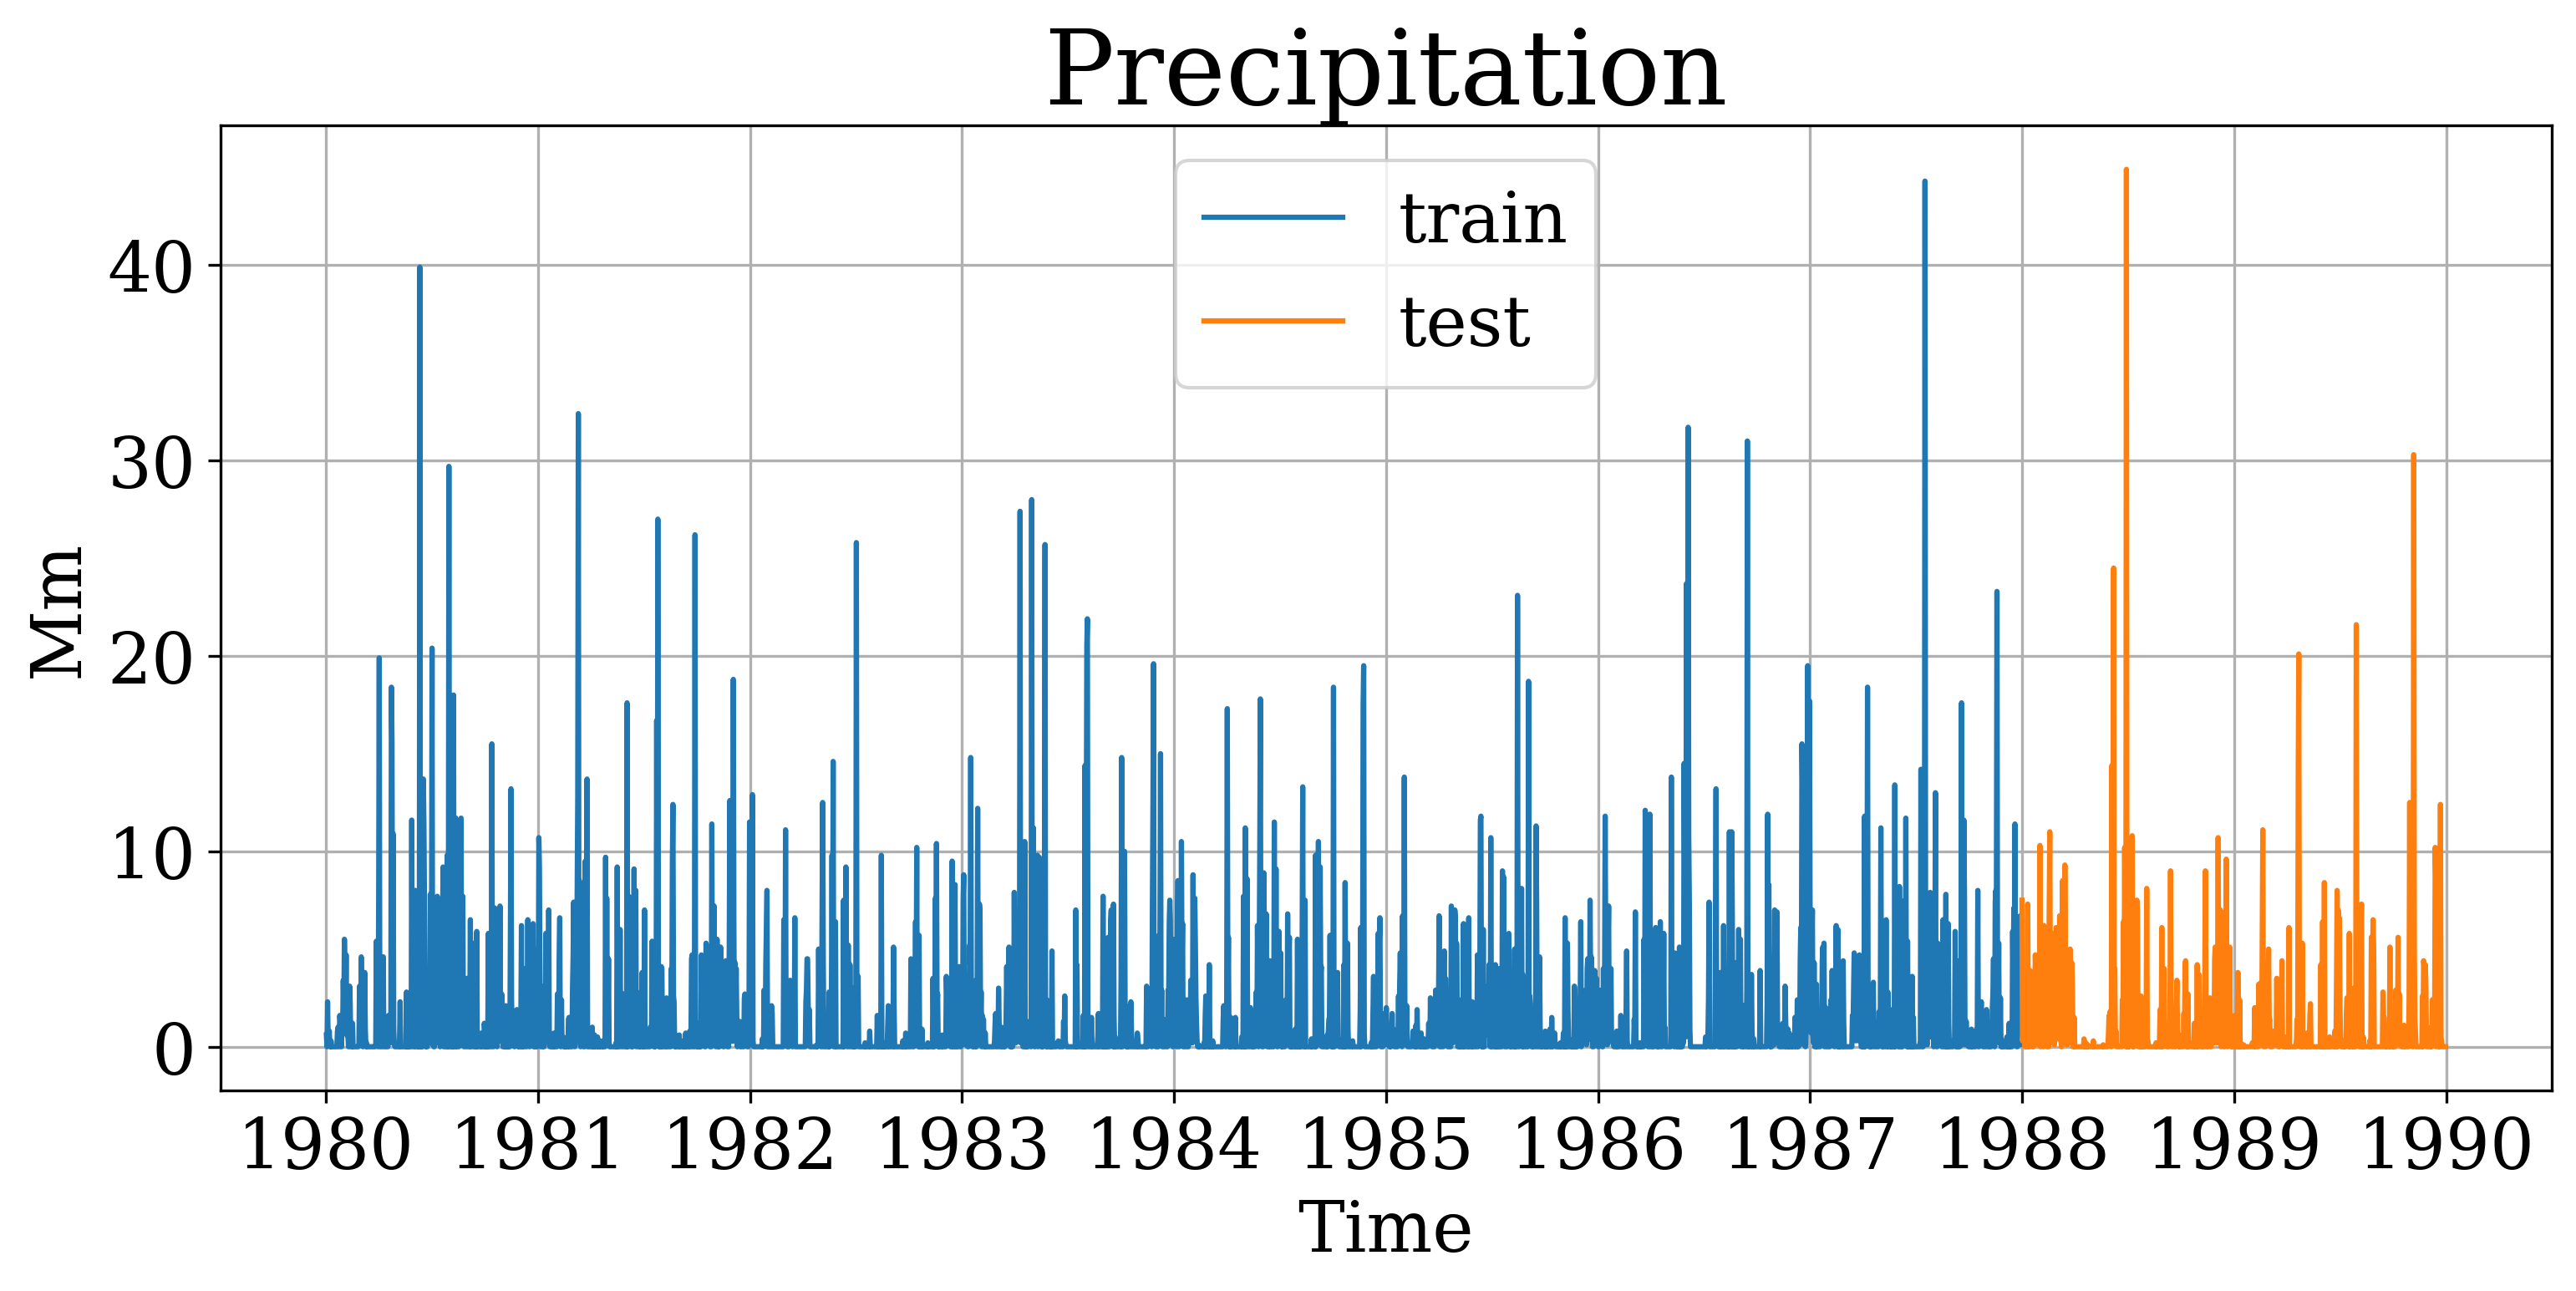

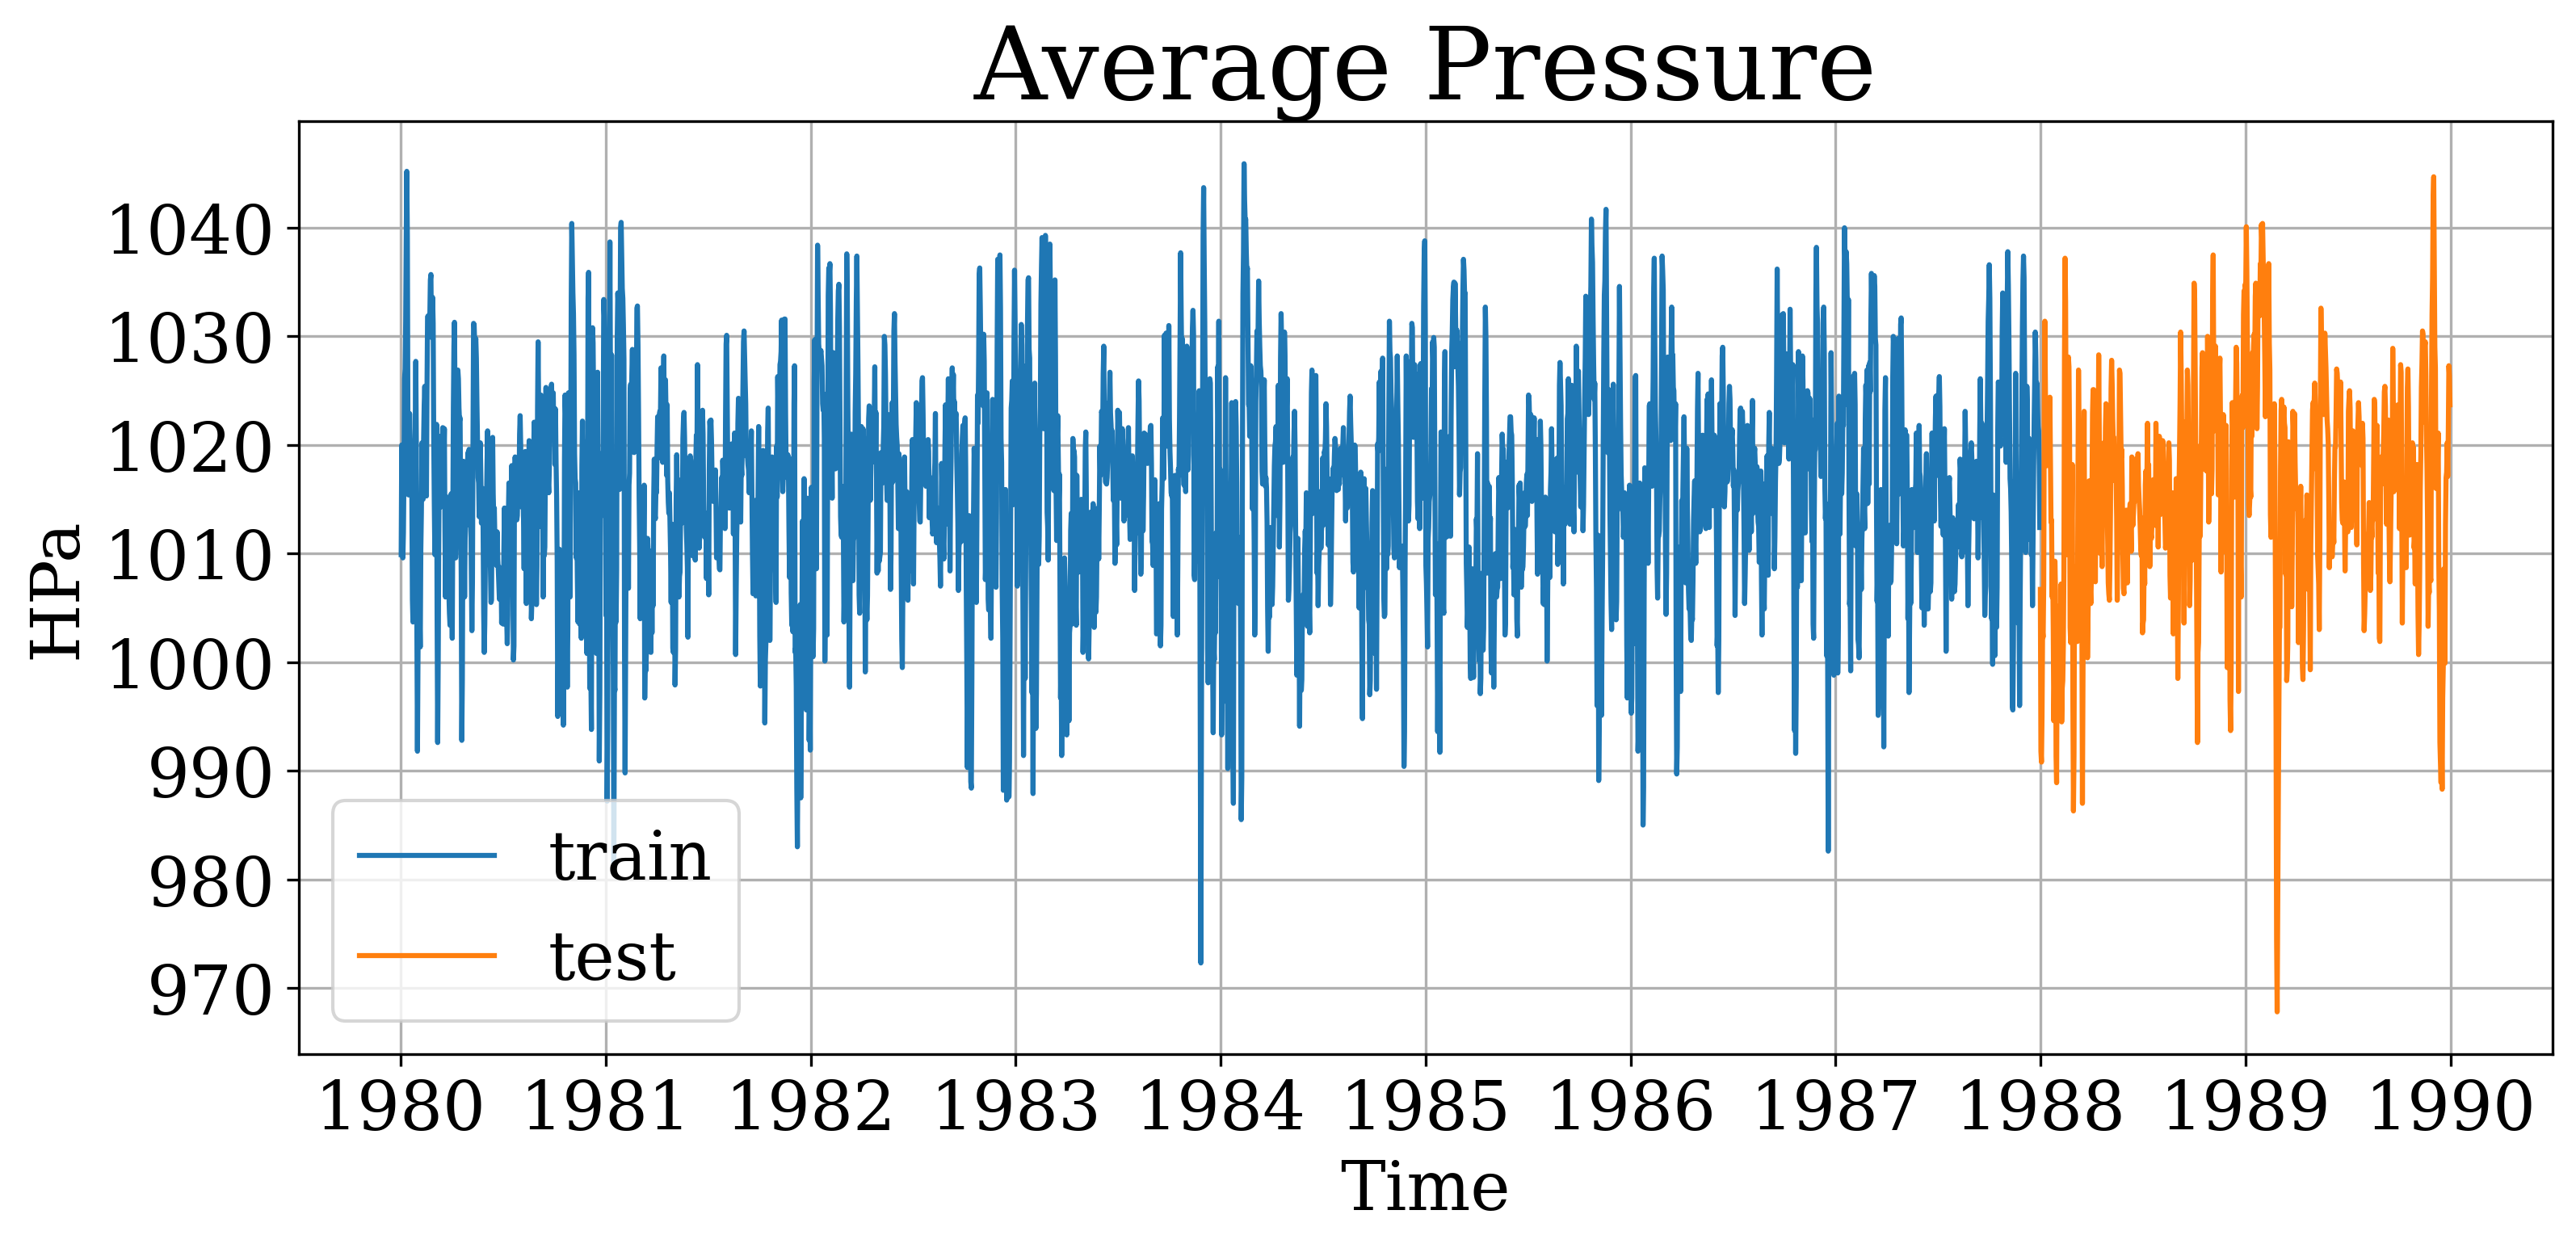

In [8]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(12, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

## Global method parameters

In [9]:
# for consitency along diffrent methods they share alike parameters
num_lags = 500

## VAR fitting

In [10]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

In [11]:
# load model if it already exists
if pathlib.Path(f'./saved_model/var_model.pkl').exists():
    with open(f'./saved_model/var_model.pkl', 'rb') as f:
        var_result = pickle.load(f)
else:
    var_model = VAR(train_data)

    var_result = var_model.fit(num_lags)

    # save model
    with open(f'./saved_model/var_model.pkl', 'wb') as f:
        pickle.dump(var_result, f)

In [12]:
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Apr, 2024
Time:                     14:11:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.9434
Nobs:                     2421.00    HQIC:                   12.0880
Log likelihood:          -15693.2    FPE:                    6638.07
AIC:                      8.17058    Det(Omega_mle):         1561.36
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const        -137.560765       110.809778           -1.241           0.214
L1.y1           0.928351         0.034516           26.896           0.000
L1.y2           0.008652         0.023056            0.375           0.707
L1.y3       

## Predicition

In [13]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
# last color is for prediction drawing
color_list = ['#7F27FF', '#FF8911', '#337357', '#EE4266']

In [14]:
# make directory for figures
pathlib.Path(f'./figs/prediction').mkdir(parents=True, exist_ok=True)

In [15]:
# obtain last num_lags values before test values to create forecast 
train_last_values = train_data[-num_lags:]
var_forecast = var_result.forecast(train_last_values, test_data.shape[0])

In [16]:
var_forecast.shape

(731, 3)

In [17]:
# count metrics
var_mse_metric = np.mean((var_forecast - test_data) ** 2, axis=0)

var_mape_metric = np.empty(num_signals)

for i in range(num_signals):
    non_zero_entries = (test_data[i] != 0)

    cur_mape = np.mean(
        np.abs((var_forecast[i][non_zero_entries] - test_data[i][non_zero_entries]) / test_data[i][non_zero_entries]), 
        axis=0
    )
    var_mape_metric[i] = cur_mape

print(f'MSE = {var_mse_metric}\nMAPE = {var_mape_metric}')

# create dataframe for metrics
metrics_frame = pd.DataFrame({'MSE': [var_mse_metric], 'MAPE': [var_mape_metric]}, index=['VAR']).to_csv()

MSE = [ 40.67834403  22.83956349 156.75004936]
MAPE = [0.46832583 4.63761315 3.9830428 ]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


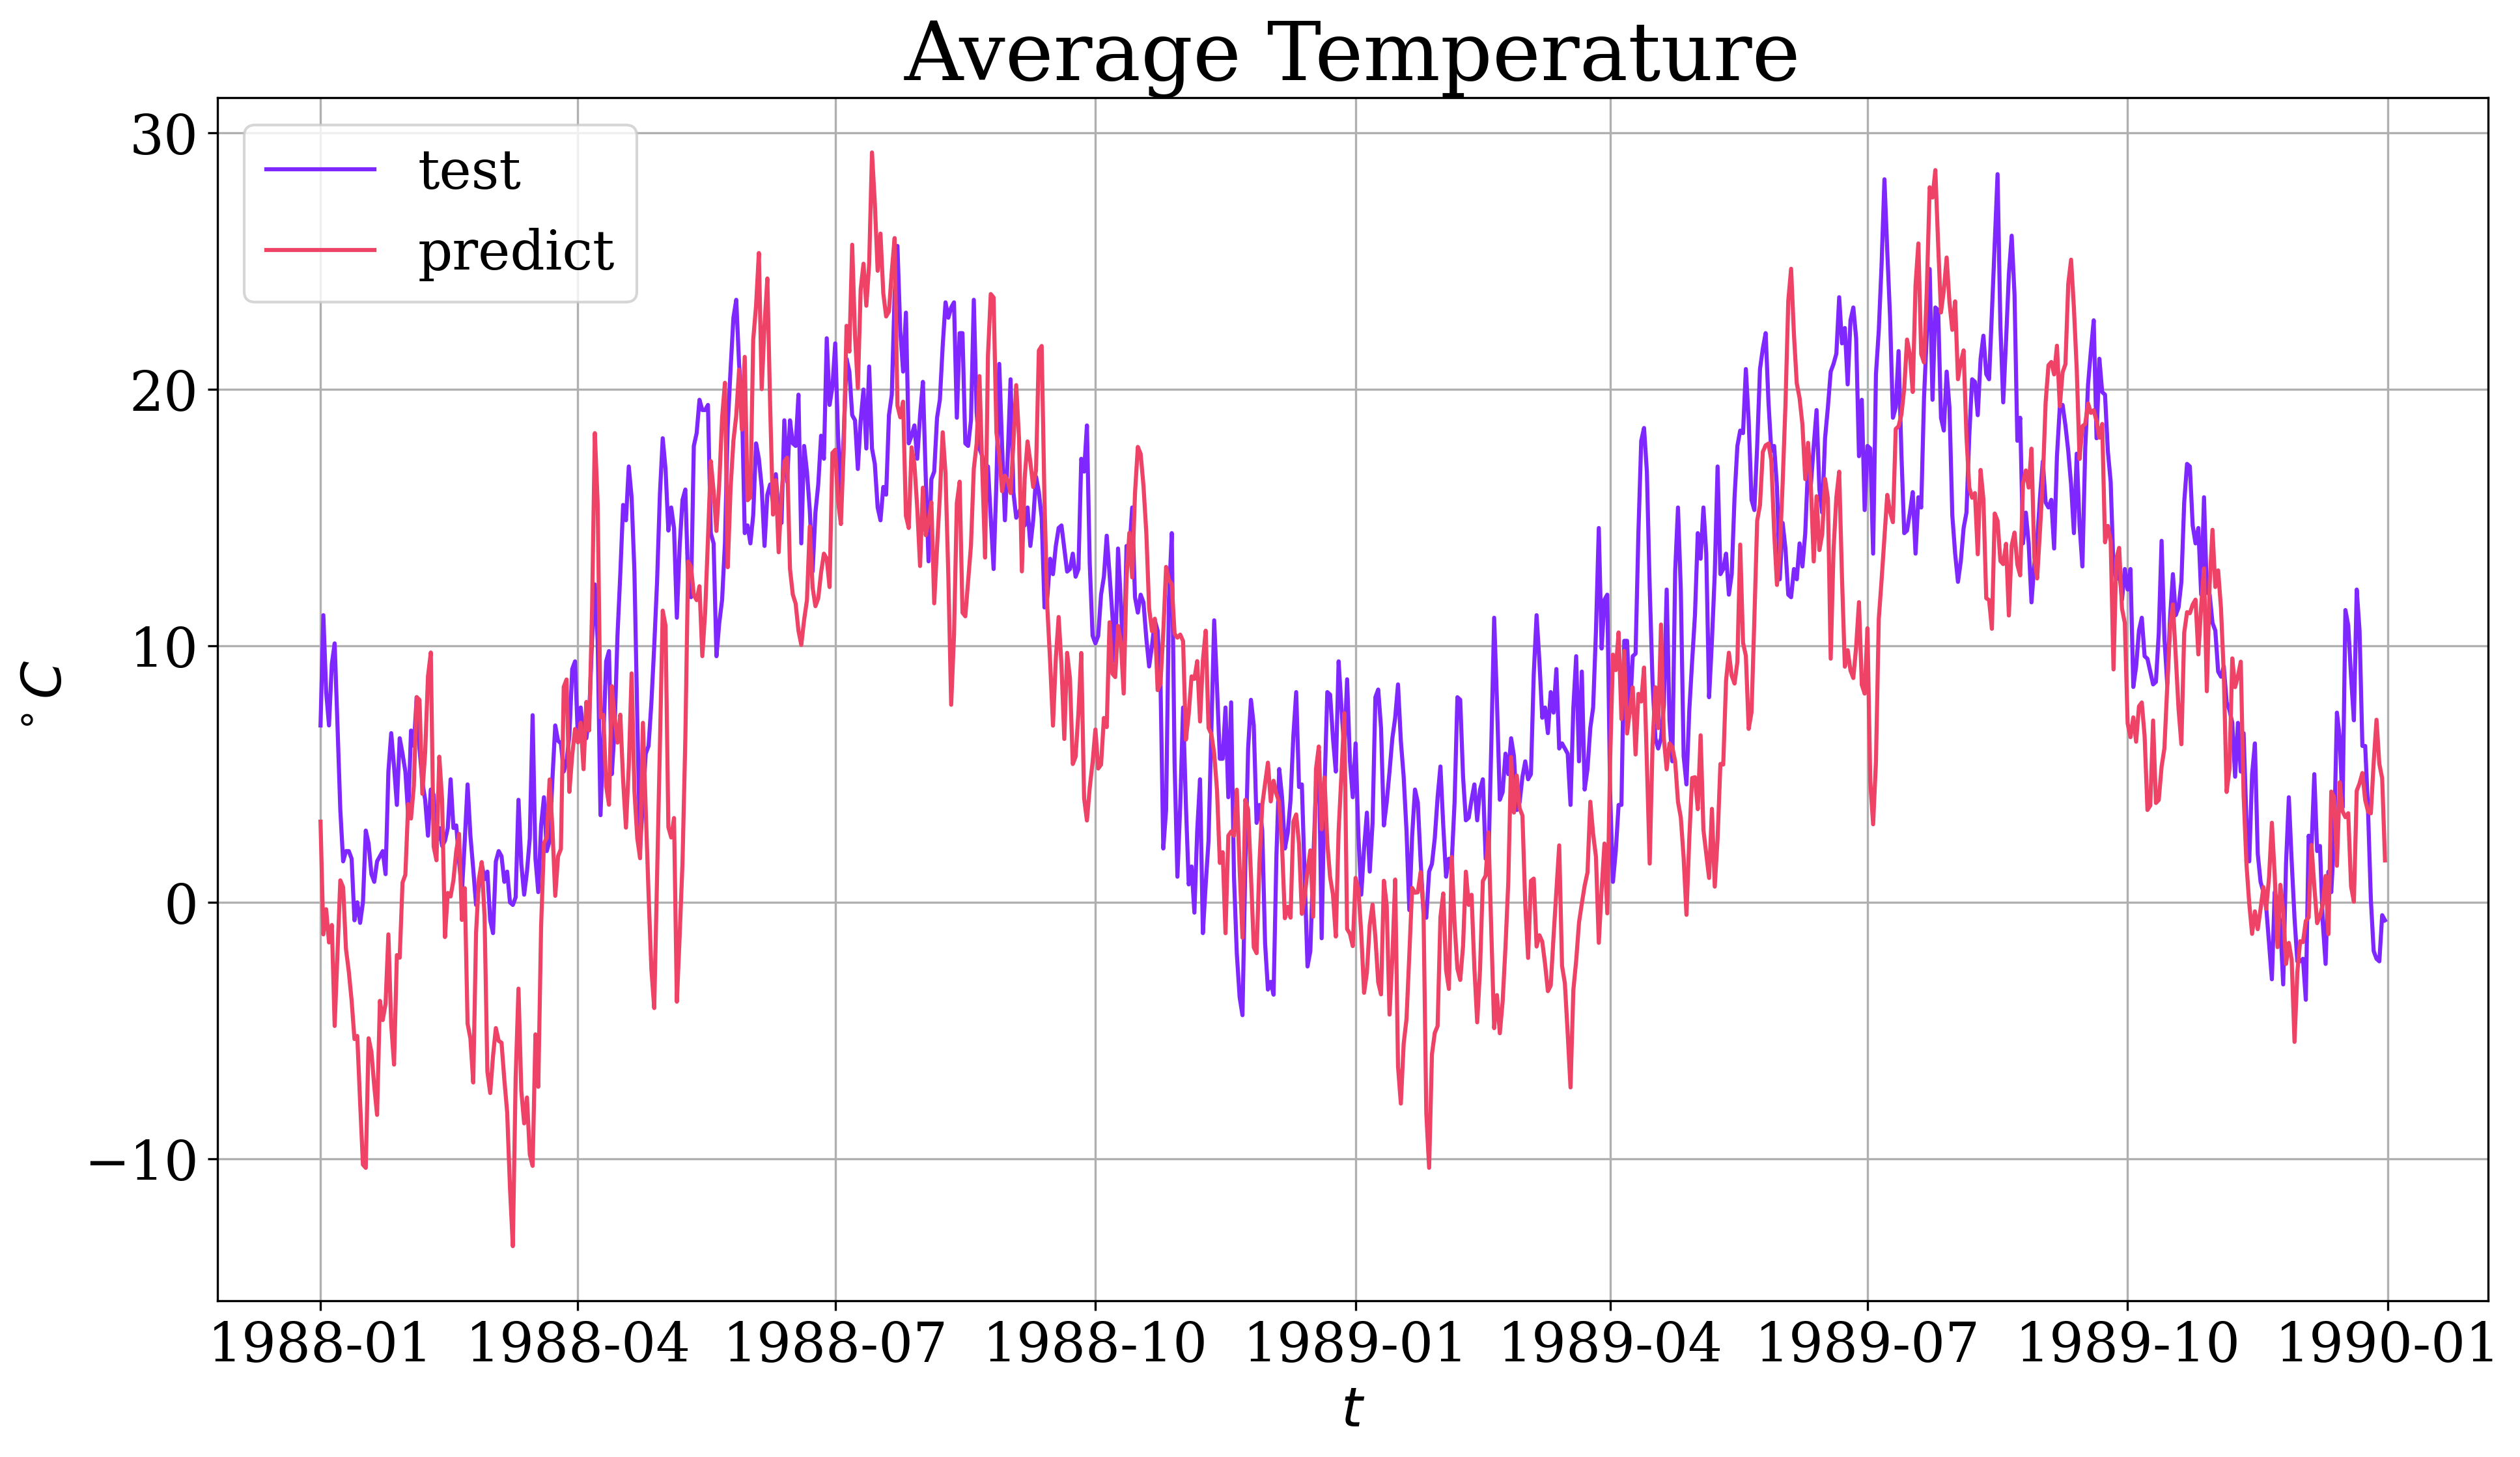

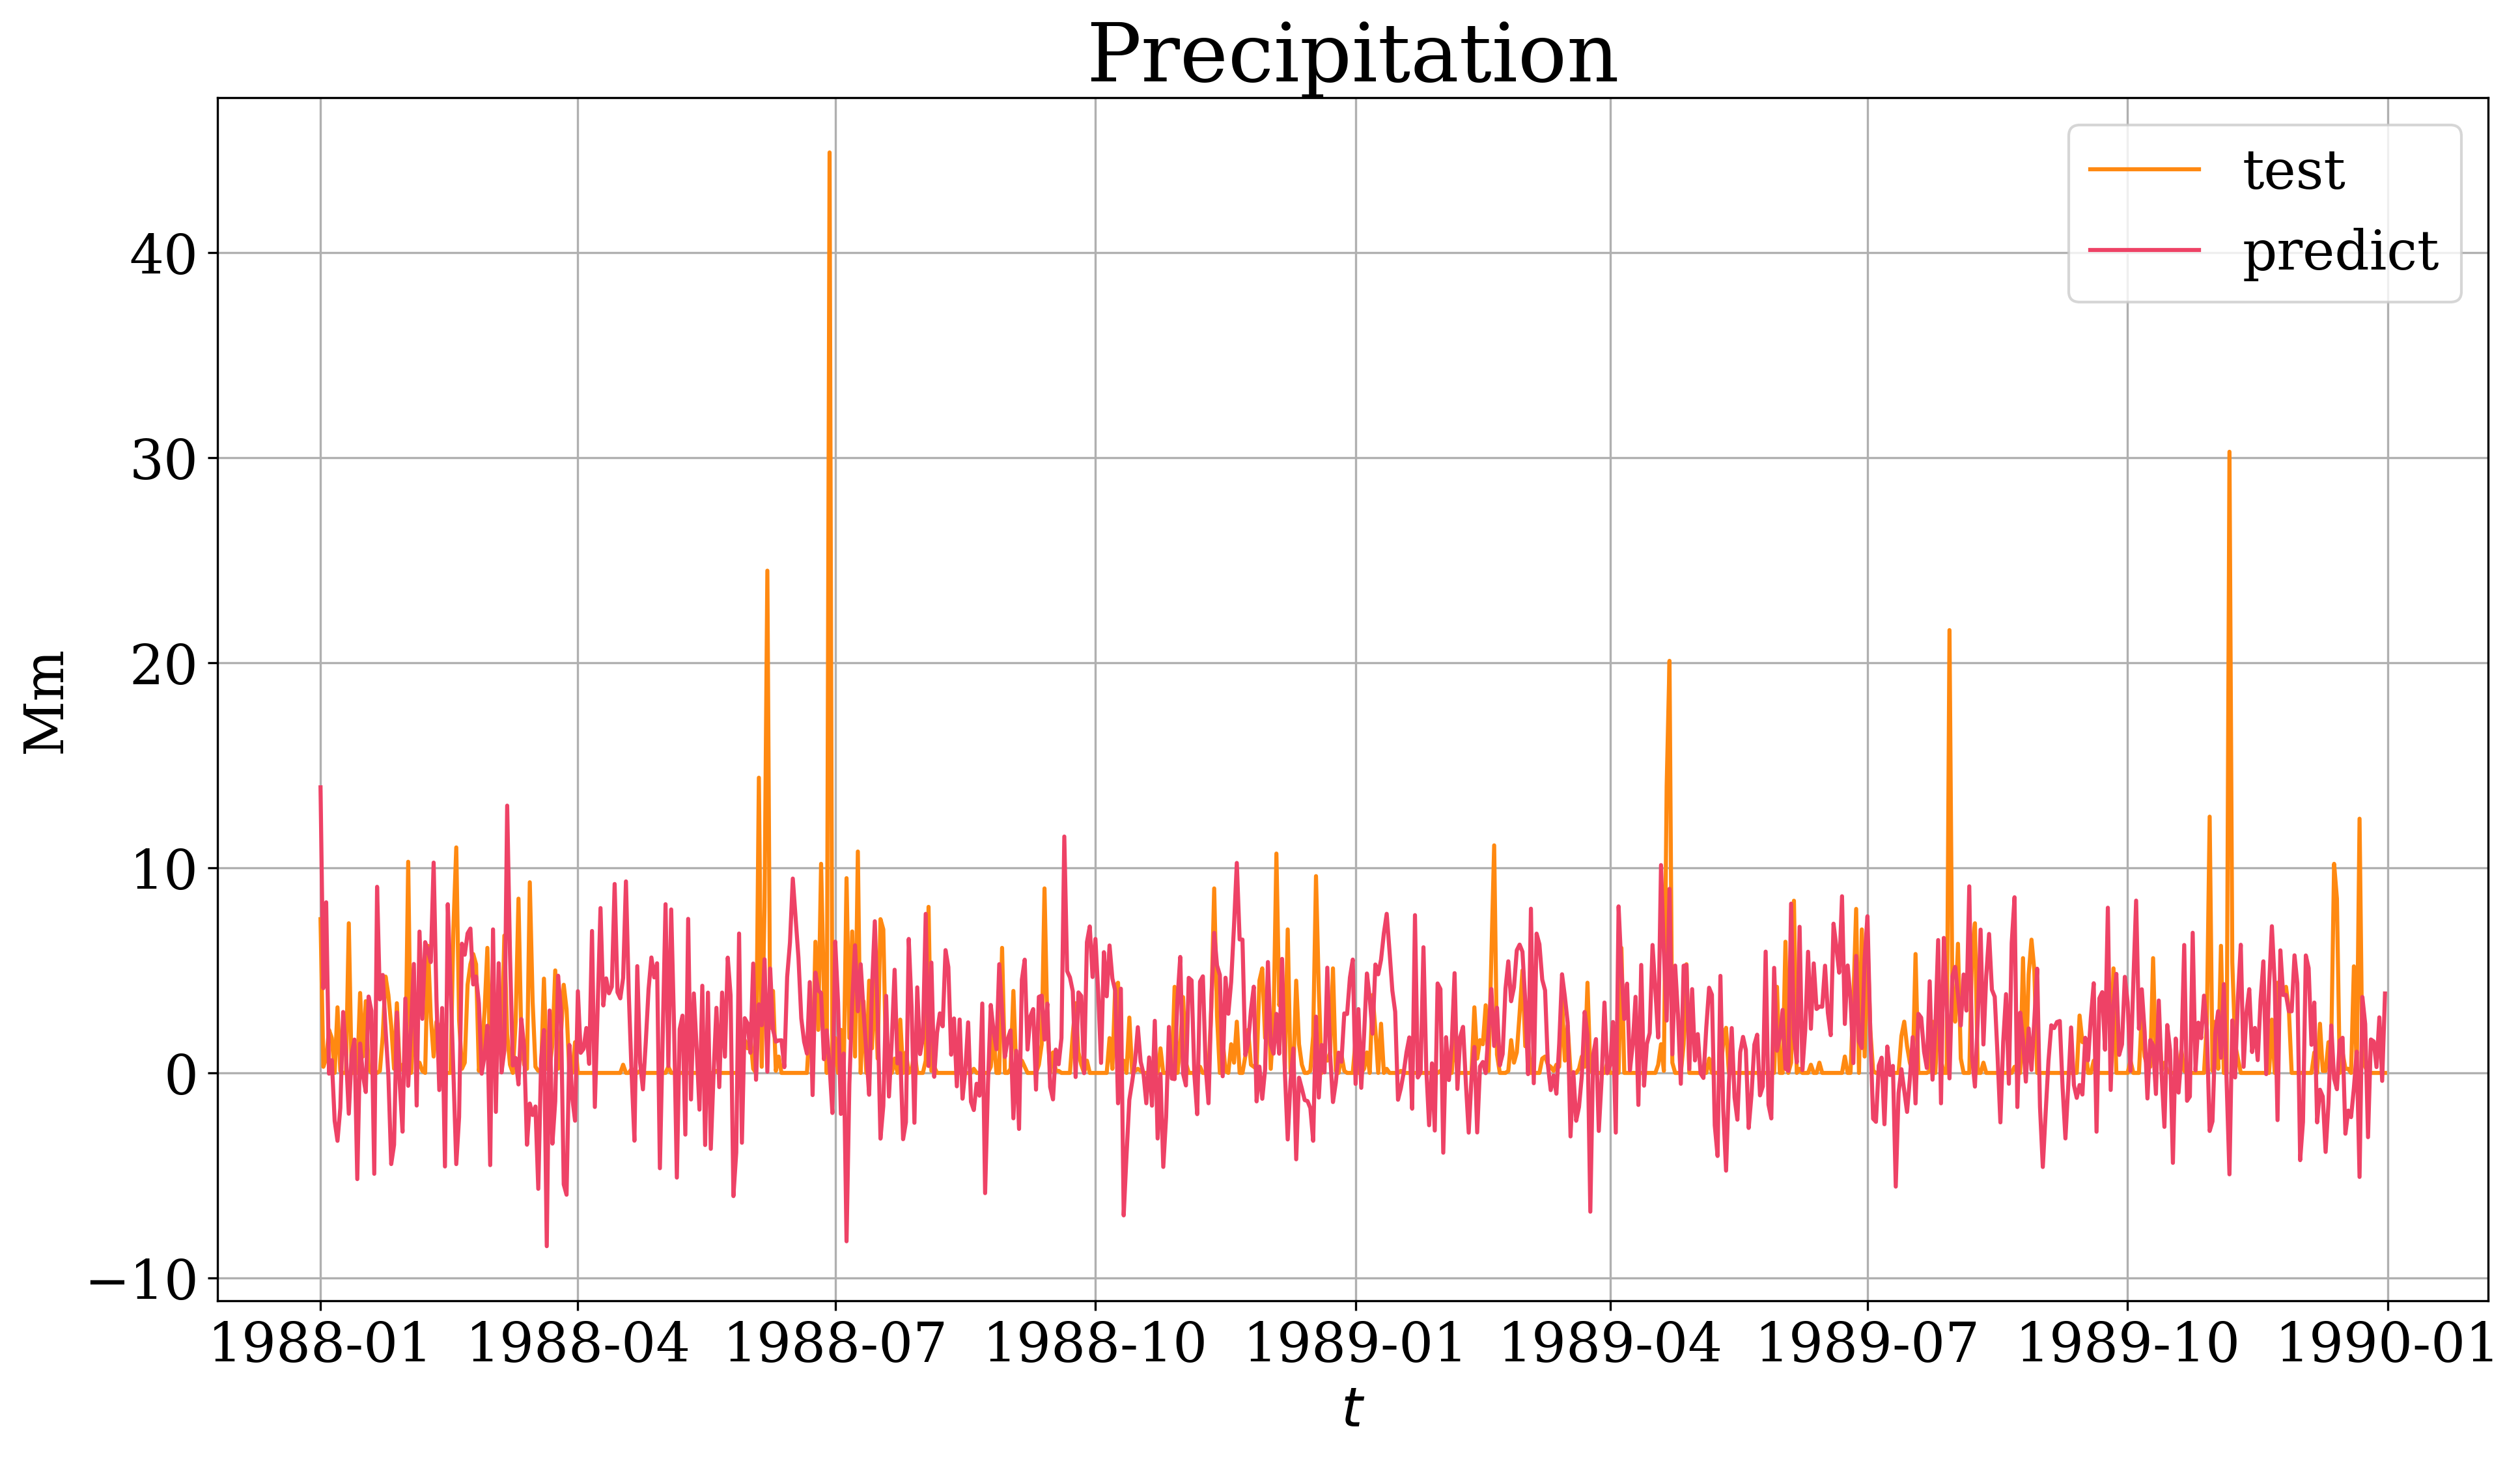

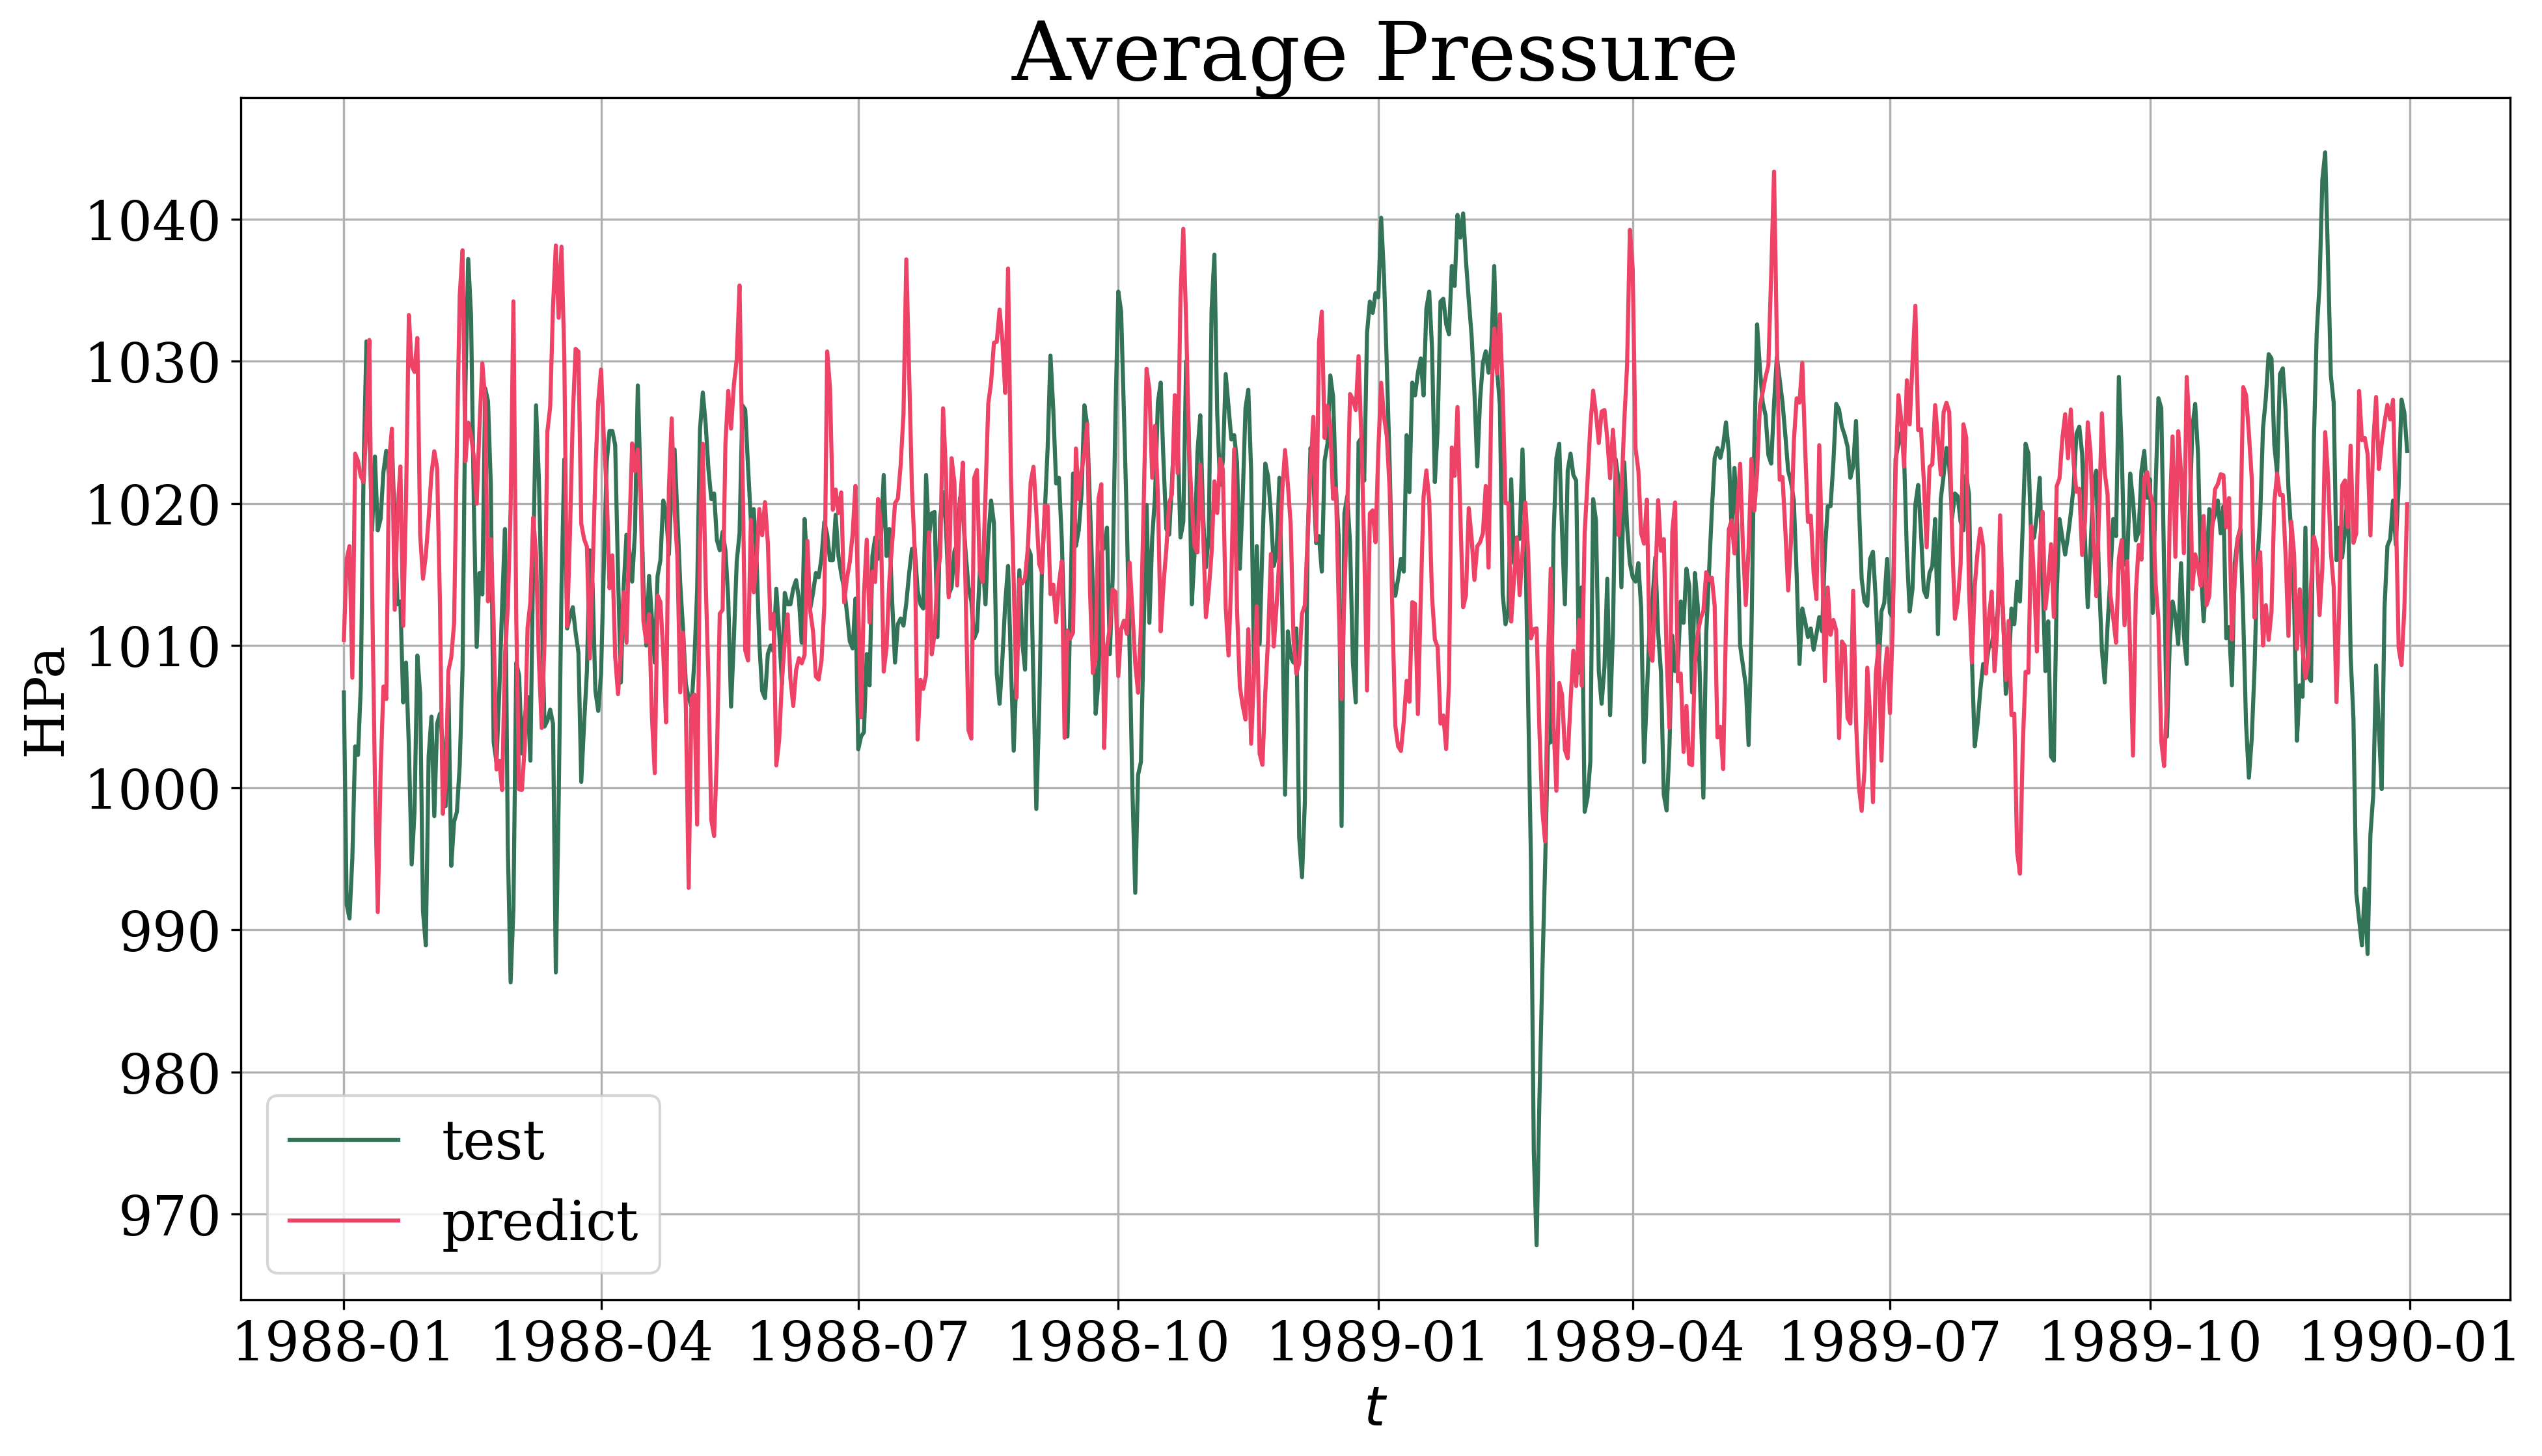

In [18]:
# plot prediction and real values
for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, var_forecast.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/{sig_names[i].replace(" ", "_")}.eps',
                             format='eps')